In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import chi2

In [2]:
ticker=['AAPL','JPM','PG']
weights=np.array([0.30,0.40,0.30])
for t in ticker:
    stock=yf.download(ticker,start='2024-5-21',end='2025-11-21',auto_adjust=False)['Adj Close']
    


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


In [3]:
stock.tail()

Ticker,AAPL,JPM,PG
Date,,,
2025-11-14,272.410004,303.609985,147.669998
2025-11-17,267.459991,300.369995,145.820007
2025-11-18,267.440002,299.410004,146.990005
2025-11-19,268.559998,303.269989,146.990005
2025-11-20,266.250000,298.380005,148.190002


In [4]:
returns_df=np.log(stock/stock.shift(1)).dropna()
returns_df

Ticker,AAPL,JPM,PG
Date,,,
2024-05-22,-0.007567,-0.006083,-0.003213
2024-05-23,-0.021283,-0.007034,-0.013922
2024-05-24,0.016452,0.019064,-0.000967
2024-05-28,0.000053,-0.006047,-0.013519
2024-05-29,0.001578,-0.006992,-0.008991
...,...,...,...
2025-11-14,-0.001980,-0.019150,-0.001962
2025-11-17,-0.018338,-0.010729,-0.012607
2025-11-18,-0.000075,-0.003201,0.007992


In [5]:
portfolio_returns=returns_df.dot(weights).dropna()
portfolio_returns

Date
2024-05-22   -0.005667
2024-05-23   -0.013375
2024-05-24    0.012271
2024-05-28   -0.006459
2024-05-29   -0.005021
                ...   
2025-11-14   -0.008843
2025-11-17   -0.013575
2025-11-18    0.001095
2025-11-19    0.006378
2025-11-20   -0.006655
Length: 377, dtype: float64

In [6]:
#Historical Var and Expected Shortfall

In [7]:
def historical_var(returns, confidence=0.99):
    return np.percentile(returns, (1 - confidence) * 100)

def historical_es(returns, confidence=0.99):
    var = historical_var(returns, confidence)
    return returns[returns < var].mean()

print("Historical Portfolio VaR 99%:", historical_var(portfolio_returns, 0.99))
print("Historical Portfolio ES 99%:", historical_es(portfolio_returns, 0.99))


Historical Portfolio VaR 99%: -0.024149085037134647
Historical Portfolio ES 99%: -0.04512890535751328


In [8]:
#Parametric Var and Expecetd Shortfall

In [9]:
def parametric_var_99(returns,weights, confidence=0.99):
    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std()
    z = norm.ppf(1 - confidence)
    return mu + z * sigma

def parametric_es_99(returns, weights,confidence=0.99):
    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std()
    z = norm.ppf(1 - confidence)
    return mu - sigma * norm.pdf(z) / (1 - confidence)
    
print("Parametric VaR 99%:", parametric_var_99(portfolio_returns, 0.99))
print("Parametric ES 99%:", parametric_es_99(portfolio_returns, 0.99))


Parametric VaR 99%: -0.024715522298891672
Parametric ES 99%: -0.028411015206984847


In [10]:
# MonteCarlo Var and Expected Shortfall

In [11]:
mu = returns_df.mean().values
cov = returns_df.cov().values


num_simulations = 1000

simulated_returns = np.random.multivariate_normal(mu, cov, num_simulations)

# convert to portfolio returns
sim_portfolio_returns = simulated_returns.dot(weights)

def mc_var(simulated_portfolio_returns, confidence=0.99):
    return np.percentile(simulated_portfolio_returns, (1 - confidence) * 100)

def mc_es(simulated_portfolio_returns, confidence=0.99):
    var = mc_var(simulated_portfolio_returns, confidence)
    return simulated_portfolio_returns[simulated_portfolio_returns < var].mean()

var_mc_99 = mc_var(sim_portfolio_returns, 0.99)
es_mc_99 = mc_es(sim_portfolio_returns, 0.99)

print("Monte Carlo VaR 99%:", var_mc_99)
print("Monte Carlo ES 99%:", es_mc_99)




Monte Carlo VaR 99%: -0.02667754008582641
Monte Carlo ES 99%: -0.029659301004840172


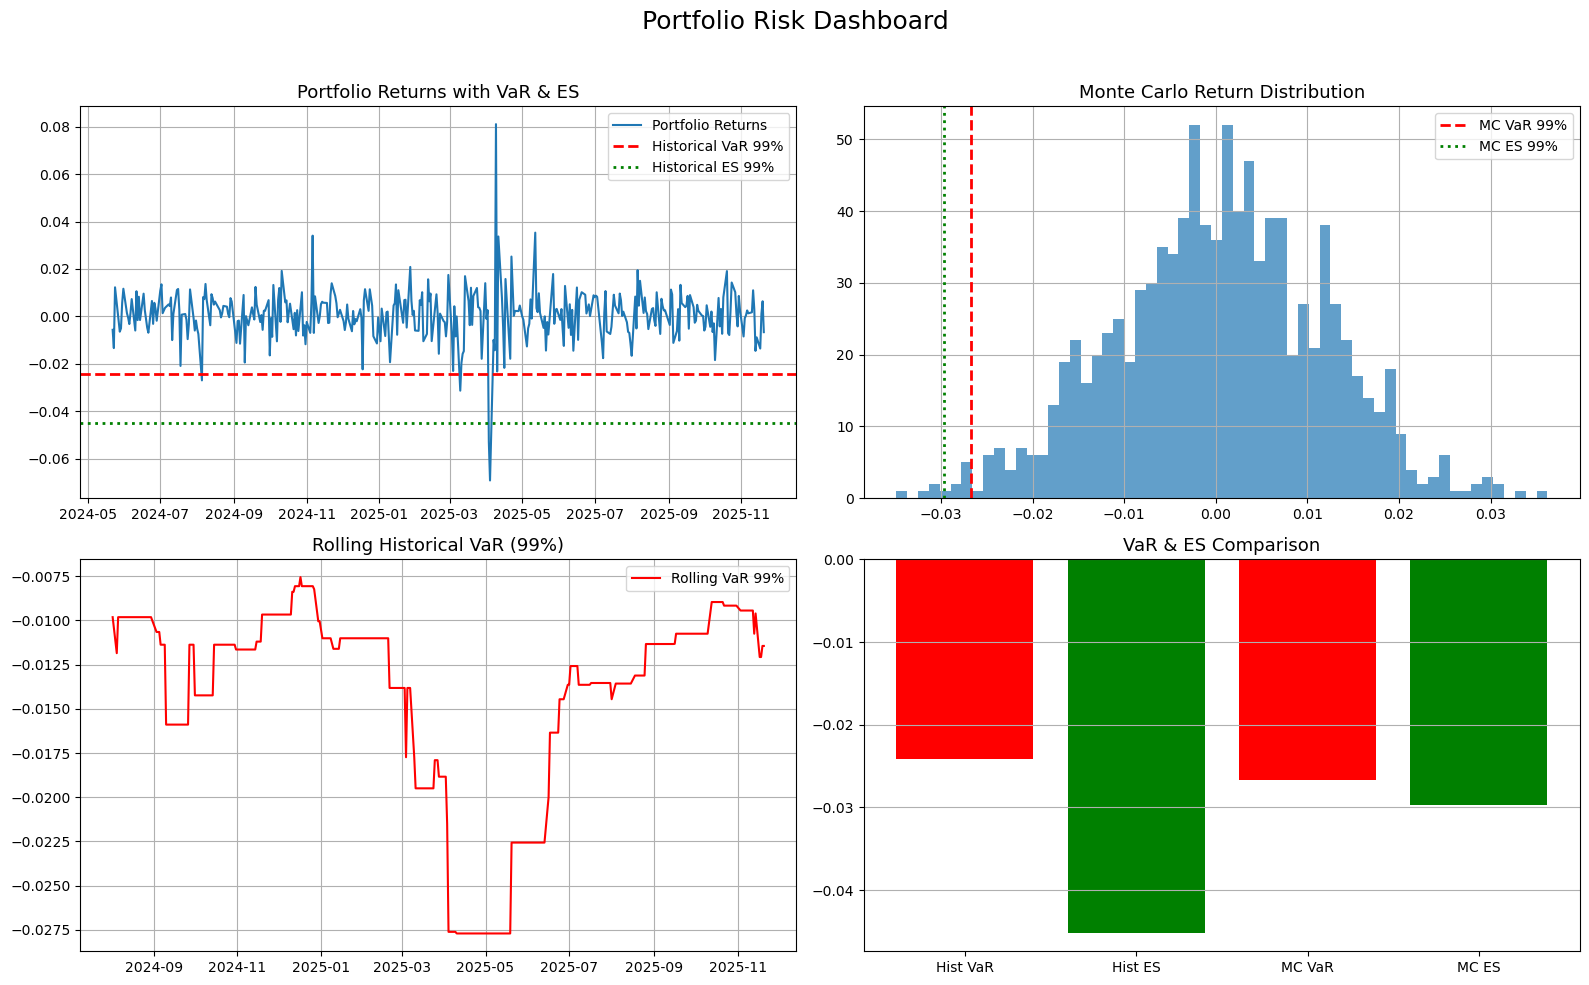

In [30]:
var_99 = historical_var(portfolio_returns, 0.99)
es_99 = historical_es(portfolio_returns, 0.99)

window = 50
rolling_var_99 = portfolio_returns.rolling(window).apply(lambda x: np.percentile(x, 5), raw=True)

fig, axes = plt.subplots(2, 2, figsize=(16,10))


# Panel 1 — Time Series + VaR

axes[0,0].plot(portfolio_returns, label="Portfolio Returns", linewidth=1.5)
axes[0,0].axhline(var_99, color="red", linestyle="--", linewidth=2, label=f"Historical VaR 99%")
axes[0,0].axhline(es_99, color="green", linestyle=":", linewidth=2, label=f"Historical ES 99%")
axes[0,0].set_title("Portfolio Returns with VaR & ES", fontsize=13)
axes[0,0].legend()
axes[0,0].grid(True)


# Panel 2 — Monte Carlo Histogram

axes[0,1].hist(sim_portfolio_returns, bins=60, alpha=0.7)
axes[0,1].axvline(var_mc_99, color="red", linestyle="--", linewidth=2, label="MC VaR 99%")
axes[0,1].axvline(es_mc_99, color="green", linestyle=":", linewidth=2, label="MC ES 99%")
axes[0,1].set_title("Monte Carlo Return Distribution", fontsize=13)
axes[0,1].legend()
axes[0,1].grid(True)


# Panel 3 — Rolling Historical VaR

axes[1,0].plot(rolling_var_99, color="red", linewidth=1.5, label="Rolling VaR 99%")
axes[1,0].set_title("Rolling Historical VaR (99%)", fontsize=13)
axes[1,0].legend()
axes[1,0].grid(True)


# Panel 4 — Side-by-side VaR vs ES

labels = ["Hist VaR", "Hist ES", "MC VaR", "MC ES"]
values = [var_99, es_99, var_mc_99, es_mc_99]
colors = ["red", "green", "red", "green"]

axes[1,1].bar(labels, values, color=colors)
axes[1,1].set_title("VaR & ES Comparison", fontsize=13)
axes[1,1].grid(axis="y")


# Overall layout
plt.suptitle("Portfolio Risk Dashboard", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




# Stress test

In [13]:
# Scenario:Market Crisis variables stressed:mean, volatality and correlation

In [14]:
# Crisis Stress Test Parameters 
mean_shock      = -0.07     # −7% daily mean collapse
vol_multiplier  = 2.5       # Volatility increases 150% → 250% of normal
corr_shift      = 0.35      # Push correlations upward by +0.35

# 1. Shock Means (Crisis crash) 
stressed_mu = mu + mean_shock

# 2. Shock Covariance Matrix
# Extract vol (std devs)
vols = np.sqrt(np.diag(cov))

# Extract correlations
corr_matrix = cov / np.outer(vols, vols)

# Apply correlation stress → push toward +1
stressed_corr = np.clip(corr_matrix + corr_shift, -1, 1)

# Apply volatility stress
stressed_vols = vols * vol_multiplier

# Reconstruct stressed covariance matrix
stressed_cov = np.outer(stressed_vols, stressed_vols) * stressed_corr

# 3. Monte Carlo Crisis Simulation 
stressed_sim = np.random.multivariate_normal(
    stressed_mu, stressed_cov, num_simulations
)

stressed_portfolio = stressed_sim.dot(weights)

# 4. Crisis VaR & ES 
crisis_var_99 = mc_var(stressed_portfolio, 0.99)
crisis_es_99  = mc_es(stressed_portfolio, 0.99)

print("Market Crisis VaR 99%:", crisis_var_99)
print("Market Crisis ES 99%:", crisis_es_99)




Market Crisis VaR 99%: -0.14283452559530196
Market Crisis ES 99%: -0.15716595151346882
